<a href="https://colab.research.google.com/github/JumanaRahim/workshop/blob/master/LUNG_NODULE_ALEXNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pretrainedmodels
!pip install torchsummary
!pip install imutils
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 2.9 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=d4566b8b16060372a06d81cf56938248f4695b389d5735e0f4d44a5fcbc283cd
  Stored in directory: /root/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import pretrainedmodels
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
import os
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from torchsummary import summary
from torch import nn
import torch.nn.functional as F
from imutils import paths
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
root='/content/drive/MyDrive/JSRT_/dataset/dataset'

In [6]:
classes=('benign', 'malignant', 'non-nodule')

In [7]:
image_paths = list(paths.list_images('/content/drive/MyDrive/JSRT_/dataset/dataset'))

data = []
labels = []
for img_path in image_paths:
    label = img_path.split(os.path.sep)[-2]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    data.append(img)
    labels.append(label)
    
data = np.array(data)
labels = np.array(labels)

In [8]:
labels

array(['non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-nodule',
       'non-nodule', 'non-nodule', 'non-nodule', 'non-n

In [9]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
print(f"Total Number of Classes: {len(lb.classes_)}")

Total Number of Classes: 3


In [10]:
#orginal dataset

train_orginal_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
])

test_orginal_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
])    


#for data augmentation

train_augmentation_transforms = transforms.Compose([  
    #transforms.RandomCrop(32, padding=4),
    transforms.ToPILImage(),
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_augmentation_transforms = transforms.Compose([  
    #transforms.RandomCrop(32, padding=4),
    transforms.ToPILImage(),
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [11]:
# divide the data into train, validation, and test set
#(X, x_val , Y, y_val) = train_test_split(data, labels, test_size=0.2,  stratify=labels,random_state=42)
#(x_train, x_test, y_train, y_test) = train_test_split(X, Y, test_size=0.25, random_state=42)
#print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

(x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.3,random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}")

x_train examples: (172, 2048, 2048, 3)
x_test examples: (75, 2048, 2048, 3)


In [12]:
batch_size=10

In [13]:
# custom dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transforms = None):
        self.labels = labels
        self.images = images
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        data = self.images[index][:]
        labels = self.labels[index]
        
        if self.transforms:
            data = self.transforms(data)
            
            return data,labels
                    
train_orginal_data = CustomDataset(x_train, y_train, train_orginal_transforms)
test_orginal_data = CustomDataset(x_test, y_test, test_orginal_transforms)     


train_augmentation_data = CustomDataset(x_train, y_train, train_augmentation_transforms )
test_augmentation_data = CustomDataset(x_test, y_test, test_augmentation_transforms )  

train_data = torch.utils.data.ConcatDataset([train_orginal_data,train_augmentation_data])
print(len(train_data))
test_data = torch.utils.data.ConcatDataset([test_orginal_data,test_augmentation_data])
print(len(test_data))




trainLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testLoader = DataLoader(test_data, batch_size=batch_size, shuffle=True) 

344
150


In [14]:
for X, y in trainLoader:

      print(f"Shape of X [N, C, H, W]: {X.shape}")
      print(f"Shape of y: {y.shape} {y.dtype}")
      break

Shape of X [N, C, H, W]: torch.Size([10, 3, 227, 227])
Shape of y: torch.Size([10]) torch.int64


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [17]:

class AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
model = AlexNet().to(device)
print(model)

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  

In [18]:
num_classes = 3
num_epochs = 50
batch_size = 10
learning_rate = 0.001

model = AlexNet(num_classes).to(device)


# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
#optimizer= torch.optim.Adam(model.parameters(), lr= learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.005)
#optimizer=torch.optim.RMSprop(model.parameters(), lr= learning_rate, alpha=0.99, eps=1e-08, weight_decay=0.005, momentum=0.9)


# Train the model
total_step = len(trainLoader)

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)
summary(model, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
       BatchNorm2d-2           [-1, 96, 55, 55]             192
              ReLU-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
       BatchNorm2d-6          [-1, 256, 27, 27]             512
              ReLU-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
      BatchNorm2d-10          [-1, 384, 13, 13]             768
             ReLU-11          [-1, 384, 13, 13]               0
           Conv2d-12          [-1, 384, 13, 13]       1,327,488
      BatchNorm2d-13          [-1, 384, 13, 13]             768
             ReLU-14          [-1, 384,

In [20]:
def train(model,dataloader):    
    # training function

    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    total=0
    for batch, (X, y) in enumerate(tqdm(dataloader)):


        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_correct += (outputs.argmax(1) == y).type(torch.float).sum().item()
        total += y.size(0)

    loss = running_loss/len(dataloader)
    accuracy = 100.*running_correct/total
    print('Train Loss: %.3f | Accuracy: %.3f'%(loss, accuracy))


    #print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")


    return loss, accuracy

In [21]:
#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total=0
    with torch.no_grad():
        
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)
            running_loss += loss_fn(pred, y).item()        
            running_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            total += y.size(0)
        
    loss = running_loss/len(dataloader)
    accuracy = 100.*running_correct/total
    #print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}')
    print('Test Loss: %.3f | Accuracy: %.3f'%(loss, accuracy))


    return loss, accuracy

In [22]:
from array import array
np_arr = np.ones((227, 227))
torch_tensor = torch.from_numpy(np_arr).long()
type(np_arr)

numpy.ndarray

In [23]:
epochs=50


train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
print(f"Training on {len(train_data)} examples, validating on {len(test_data)} examples...")

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = train(model, trainLoader)
    val_epoch_loss, val_epoch_accuracy = validate(model, testLoader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

Training on 344 examples, validating on 150 examples...
Epoch 1 of 50
Training


100%|██████████| 35/35 [01:14<00:00,  2.12s/it]


Train Loss: 1.145 | Accuracy: 46.221
Validating
Test Loss: 1.130 | Accuracy: 32.000
Epoch 2 of 50
Training


100%|██████████| 35/35 [01:08<00:00,  1.96s/it]


Train Loss: 1.125 | Accuracy: 39.535
Validating
Test Loss: 1.215 | Accuracy: 33.333
Epoch 3 of 50
Training


100%|██████████| 35/35 [01:10<00:00,  2.01s/it]


Train Loss: 1.116 | Accuracy: 38.663
Validating
Test Loss: 1.111 | Accuracy: 38.000
Epoch 4 of 50
Training


100%|██████████| 35/35 [01:09<00:00,  1.97s/it]


Train Loss: 1.085 | Accuracy: 42.733
Validating
Test Loss: 1.103 | Accuracy: 37.333
Epoch 5 of 50
Training


100%|██████████| 35/35 [01:08<00:00,  1.96s/it]


Train Loss: 1.087 | Accuracy: 44.767
Validating
Test Loss: 1.119 | Accuracy: 39.333
Epoch 6 of 50
Training


100%|██████████| 35/35 [01:06<00:00,  1.89s/it]


Train Loss: 1.135 | Accuracy: 42.151
Validating
Test Loss: 1.113 | Accuracy: 38.667
Epoch 7 of 50
Training


100%|██████████| 35/35 [01:09<00:00,  1.98s/it]


Train Loss: 1.069 | Accuracy: 44.767
Validating
Test Loss: 1.178 | Accuracy: 36.000
Epoch 8 of 50
Training


100%|██████████| 35/35 [01:05<00:00,  1.88s/it]


Train Loss: 1.120 | Accuracy: 40.116
Validating
Test Loss: 1.091 | Accuracy: 42.667
Epoch 9 of 50
Training


100%|██████████| 35/35 [01:07<00:00,  1.93s/it]


Train Loss: 1.116 | Accuracy: 42.151
Validating
Test Loss: 1.135 | Accuracy: 33.333
Epoch 10 of 50
Training


100%|██████████| 35/35 [01:08<00:00,  1.96s/it]


Train Loss: 1.061 | Accuracy: 42.442
Validating
Test Loss: 1.089 | Accuracy: 39.333
Epoch 11 of 50
Training


100%|██████████| 35/35 [01:22<00:00,  2.35s/it]


Train Loss: 1.071 | Accuracy: 42.442
Validating
Test Loss: 1.092 | Accuracy: 39.333
Epoch 12 of 50
Training


100%|██████████| 35/35 [01:18<00:00,  2.24s/it]


Train Loss: 1.059 | Accuracy: 42.442
Validating
Test Loss: 1.102 | Accuracy: 38.667
Epoch 13 of 50
Training


100%|██████████| 35/35 [01:07<00:00,  1.93s/it]


Train Loss: 1.063 | Accuracy: 42.733
Validating
Test Loss: 1.092 | Accuracy: 38.667
Epoch 14 of 50
Training


100%|██████████| 35/35 [01:04<00:00,  1.85s/it]


Train Loss: 1.031 | Accuracy: 47.965
Validating
Test Loss: 1.108 | Accuracy: 42.667
Epoch 15 of 50
Training


100%|██████████| 35/35 [01:06<00:00,  1.89s/it]


Train Loss: 1.074 | Accuracy: 43.314
Validating
Test Loss: 1.106 | Accuracy: 40.000
Epoch 16 of 50
Training


100%|██████████| 35/35 [01:04<00:00,  1.84s/it]


Train Loss: 1.064 | Accuracy: 44.767
Validating
Test Loss: 1.085 | Accuracy: 41.333
Epoch 17 of 50
Training


100%|██████████| 35/35 [01:04<00:00,  1.84s/it]


Train Loss: 1.038 | Accuracy: 49.128
Validating
Test Loss: 1.084 | Accuracy: 40.667
Epoch 18 of 50
Training


100%|██████████| 35/35 [01:08<00:00,  1.95s/it]


Train Loss: 1.044 | Accuracy: 42.151
Validating
Test Loss: 1.128 | Accuracy: 40.000
Epoch 19 of 50
Training


100%|██████████| 35/35 [01:05<00:00,  1.87s/it]


Train Loss: 1.041 | Accuracy: 46.802
Validating
Test Loss: 1.079 | Accuracy: 43.333
Epoch 20 of 50
Training


100%|██████████| 35/35 [01:06<00:00,  1.89s/it]


Train Loss: 1.028 | Accuracy: 49.709
Validating
Test Loss: 1.088 | Accuracy: 38.667
Epoch 21 of 50
Training


100%|██████████| 35/35 [01:04<00:00,  1.84s/it]


Train Loss: 1.051 | Accuracy: 46.512
Validating
Test Loss: 1.070 | Accuracy: 42.667
Epoch 22 of 50
Training


100%|██████████| 35/35 [01:06<00:00,  1.89s/it]


Train Loss: 1.035 | Accuracy: 47.384
Validating
Test Loss: 1.073 | Accuracy: 44.667
Epoch 23 of 50
Training


100%|██████████| 35/35 [01:05<00:00,  1.86s/it]


Train Loss: 1.041 | Accuracy: 46.802
Validating
Test Loss: 1.104 | Accuracy: 34.667
Epoch 24 of 50
Training


100%|██████████| 35/35 [01:06<00:00,  1.90s/it]


Train Loss: 1.031 | Accuracy: 49.419
Validating
Test Loss: 1.095 | Accuracy: 44.000
Epoch 25 of 50
Training


100%|██████████| 35/35 [01:05<00:00,  1.86s/it]


Train Loss: 1.027 | Accuracy: 51.453
Validating
Test Loss: 1.077 | Accuracy: 42.000
Epoch 26 of 50
Training


100%|██████████| 35/35 [01:05<00:00,  1.88s/it]


Train Loss: 1.024 | Accuracy: 50.581
Validating
Test Loss: 1.080 | Accuracy: 46.667
Epoch 27 of 50
Training


100%|██████████| 35/35 [01:04<00:00,  1.84s/it]


Train Loss: 1.013 | Accuracy: 50.291
Validating
Test Loss: 1.083 | Accuracy: 37.333
Epoch 28 of 50
Training


100%|██████████| 35/35 [01:04<00:00,  1.85s/it]


Train Loss: 1.036 | Accuracy: 48.837
Validating
Test Loss: 1.078 | Accuracy: 43.333
Epoch 29 of 50
Training


100%|██████████| 35/35 [01:06<00:00,  1.89s/it]


Train Loss: 1.015 | Accuracy: 50.291
Validating
Test Loss: 1.098 | Accuracy: 45.333
Epoch 30 of 50
Training


100%|██████████| 35/35 [01:04<00:00,  1.86s/it]


Train Loss: 1.012 | Accuracy: 53.488
Validating
Test Loss: 1.102 | Accuracy: 42.667
Epoch 31 of 50
Training


100%|██████████| 35/35 [01:06<00:00,  1.89s/it]


Train Loss: 1.009 | Accuracy: 50.291
Validating
Test Loss: 1.126 | Accuracy: 42.667
Epoch 32 of 50
Training


100%|██████████| 35/35 [01:04<00:00,  1.85s/it]


Train Loss: 0.988 | Accuracy: 50.581
Validating
Test Loss: 1.090 | Accuracy: 42.667
Epoch 33 of 50
Training


100%|██████████| 35/35 [01:07<00:00,  1.93s/it]


Train Loss: 1.010 | Accuracy: 50.872
Validating
Test Loss: 1.099 | Accuracy: 41.333
Epoch 34 of 50
Training


100%|██████████| 35/35 [01:04<00:00,  1.85s/it]


Train Loss: 0.982 | Accuracy: 51.453
Validating
Test Loss: 1.052 | Accuracy: 44.667
Epoch 35 of 50
Training


100%|██████████| 35/35 [01:05<00:00,  1.86s/it]


Train Loss: 0.990 | Accuracy: 52.616
Validating
Test Loss: 1.072 | Accuracy: 39.333
Epoch 36 of 50
Training


100%|██████████| 35/35 [01:04<00:00,  1.85s/it]


Train Loss: 0.955 | Accuracy: 54.651
Validating
Test Loss: 1.057 | Accuracy: 41.333
Epoch 37 of 50
Training


100%|██████████| 35/35 [01:04<00:00,  1.85s/it]


Train Loss: 0.980 | Accuracy: 51.744
Validating
Test Loss: 1.115 | Accuracy: 36.000
Epoch 38 of 50
Training


100%|██████████| 35/35 [01:05<00:00,  1.89s/it]


Train Loss: 0.997 | Accuracy: 46.802
Validating
Test Loss: 1.070 | Accuracy: 45.333
Epoch 39 of 50
Training


100%|██████████| 35/35 [01:04<00:00,  1.85s/it]


Train Loss: 0.977 | Accuracy: 52.326
Validating
Test Loss: 1.046 | Accuracy: 48.000
Epoch 40 of 50
Training


100%|██████████| 35/35 [01:05<00:00,  1.88s/it]


Train Loss: 0.959 | Accuracy: 54.070
Validating
Test Loss: 1.047 | Accuracy: 43.333
Epoch 41 of 50
Training


100%|██████████| 35/35 [01:04<00:00,  1.84s/it]


Train Loss: 0.969 | Accuracy: 50.581
Validating
Test Loss: 1.038 | Accuracy: 44.000
Epoch 42 of 50
Training


100%|██████████| 35/35 [01:04<00:00,  1.85s/it]


Train Loss: 0.939 | Accuracy: 50.872
Validating
Test Loss: 1.042 | Accuracy: 44.000
Epoch 43 of 50
Training


100%|██████████| 35/35 [01:04<00:00,  1.84s/it]


Train Loss: 0.953 | Accuracy: 54.070
Validating
Test Loss: 1.082 | Accuracy: 42.000
Epoch 44 of 50
Training


100%|██████████| 35/35 [01:04<00:00,  1.85s/it]


Train Loss: 0.911 | Accuracy: 55.814
Validating
Test Loss: 1.063 | Accuracy: 47.333
Epoch 45 of 50
Training


100%|██████████| 35/35 [01:06<00:00,  1.89s/it]


Train Loss: 0.934 | Accuracy: 51.453
Validating
Test Loss: 1.066 | Accuracy: 44.000
Epoch 46 of 50
Training


100%|██████████| 35/35 [01:05<00:00,  1.86s/it]


Train Loss: 0.904 | Accuracy: 59.593
Validating
Test Loss: 1.110 | Accuracy: 44.667
Epoch 47 of 50
Training


100%|██████████| 35/35 [01:06<00:00,  1.90s/it]


Train Loss: 0.916 | Accuracy: 56.977
Validating
Test Loss: 1.066 | Accuracy: 41.333
Epoch 48 of 50
Training


100%|██████████| 35/35 [01:05<00:00,  1.87s/it]


Train Loss: 0.930 | Accuracy: 52.616
Validating
Test Loss: 1.034 | Accuracy: 40.667
Epoch 49 of 50
Training


100%|██████████| 35/35 [01:05<00:00,  1.86s/it]


Train Loss: 0.853 | Accuracy: 59.302
Validating
Test Loss: 1.065 | Accuracy: 48.000
Epoch 50 of 50
Training


100%|██████████| 35/35 [01:05<00:00,  1.86s/it]


Train Loss: 0.891 | Accuracy: 58.140
Validating
Test Loss: 1.050 | Accuracy: 46.000


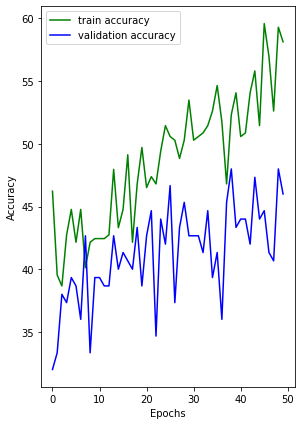

In [25]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

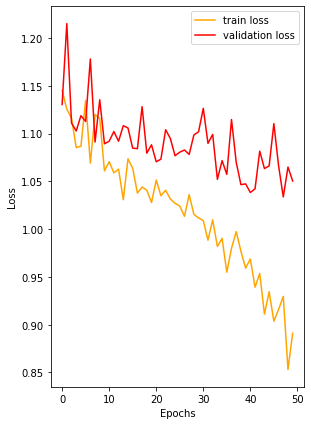

In [26]:
# loss plots
plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('../outputs/plots/loss.png')
plt.show()

In [27]:
label2class ={ 1 :'benign', 2 :'malignant', 3:'non-nodule'}

In [28]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for batch,(inputs, labels) in enumerate(testLoader):
    
    
        inputs= inputs.to(device)
        labels= labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        
        

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.67      0.14      0.24        42
           1       0.40      0.53      0.46        58
           2       0.44      0.56      0.50        50

    accuracy                           0.43       150
   macro avg       0.50      0.41      0.40       150
weighted avg       0.49      0.43      0.41       150



Text(114.0, 0.5, 'True label')

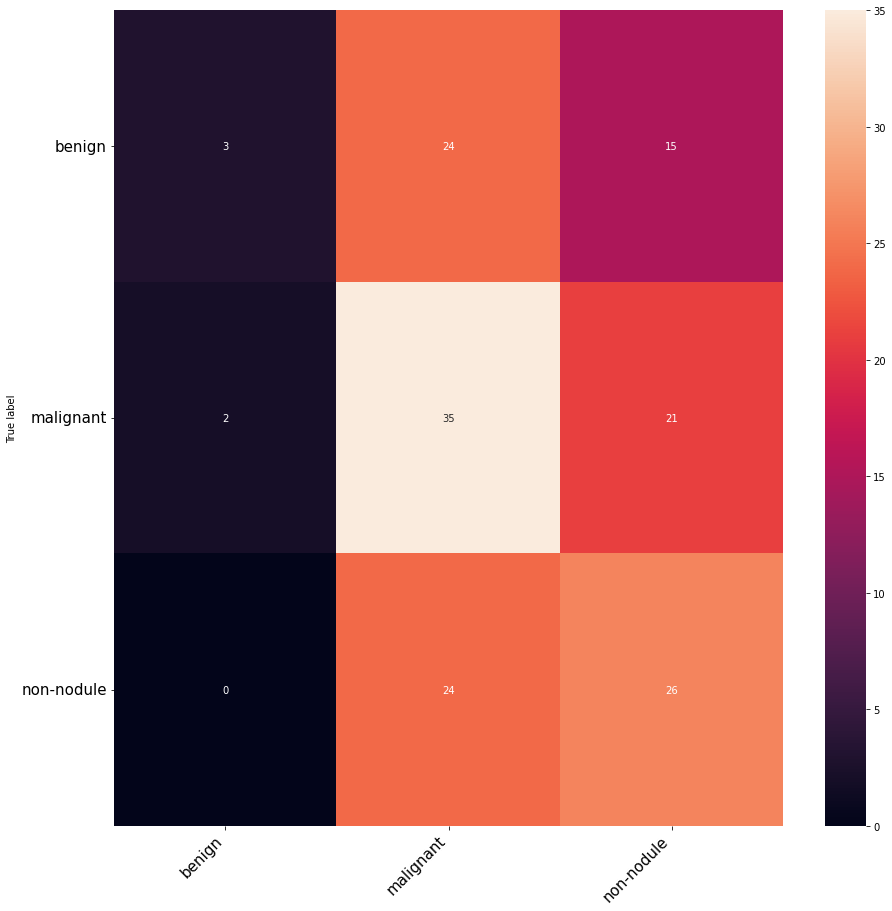

In [29]:
nb_classes = 3
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testLoader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,15))

class_names = list(label2class.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')